# Image Classification with Logistic Regression

- Logistic regression is the **workhorse** of machine learning.
- Before deep learning era, Logistic Regression was the **default** choice for solving real life classification problems with hundreds and thousands of features.
- It works in binary, multi-class and multi-label classification set ups.

# Imports

In this notebook we solve the problem of recognizing Handwritten digits using Logistic Regression model.

In [1]:
# Common imports
import numpy as np
from pprint import pprint

# to make this notebook's output stable actoss runs
np.random.seed(42)

# sklearn specific imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# scipy
from scipy.stats import loguniform # This is required while using RandomizedSearchCV


# plotting functions
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

This is to supress warnings! (Not recommended)

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

# Handwritten Digit Classification

- We are going to use `LogisticRegression` to classify and recognize given a digit image. We first apply the model for binary classification and then extend it to multiclass classification.

- Suppose we want to recognize whether the given image of digit zero or not (digits other than zero), then the problem could be cast as binary classification problem.
    - As our first step, we create a dataset, that contains a collection of digit images written by humans. Then each image should be labelled properly.
    - Fortunately, we have a standard benchmark called **MNIST**, which is what we will be using in this notebook.

In [3]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True) # This returns Data and Label as Pandas DataFrame and Series

In [4]:
# We convert these to numpy arrays.
X,y = X_pd.to_numpy(), y_pd.to_numpy()

## Pre-Processing

- Unlike the perceptrons, where scaling the range is optional (but recommended), sigmoid requires scaling the feature range between $0$ and $1$.
- **Note:** We do not apply mean centering as it removes the zeros from the data. We want the zeros to remain zeros in the dataset.
- Since we are using only one preprocessing step, we won't be using a `pipeline`.

In [5]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X = mms.fit_transform(X)

In [6]:
print("Mean of the features: ", np.mean(X))
print("Standard Deviation of the features: ", np.std(X))
print("Minimum Value: ", np.min(X))
print("Maximum Value: ", np.max(X))

Mean of the features:  0.13092720382627604
Standard Deviation of the features:  0.3084510570135976
Minimum Value:  0.0
Maximum Value:  1.0


Let's get some information about the data.

In [7]:
target_names = np.unique(y)

print('Number of samples: {0}, type: {1}'.format(X.shape[0], X.dtype))
print('Number of features: ', X.shape[1])
print('Minimum: {0}, Maximum: {1}'.format(np.min(X), np.max(X))) # Prints the maximum and minimum entry in each entry
print('Number of classes: {0}, type: {1}'.format(len(target_names),y.dtype))
print('Labels: ', target_names)

Number of samples: 70000, type: float64
Number of features:  784
Minimum: 0.0, Maximum: 1.0
Number of classes: 10, type: object
Labels:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


# Data

## Data Visualization

- We are repeating this section from the perceptron case, just to check whether feature scaling affects the images visually or not.
- Let us pick a few images (the images are already shuffled in the dataset) and display them with their respective labels. The images are stacked as row row vector of size $1 \times 784$ and therefore must be reshaped to matrix of size $28 \times 28$ in order to display them properly.

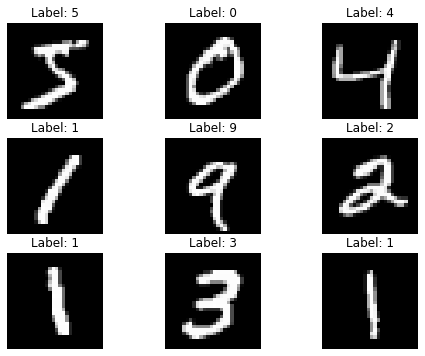

In [8]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('Label: ' + str(y[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()

We can also look at a single example.

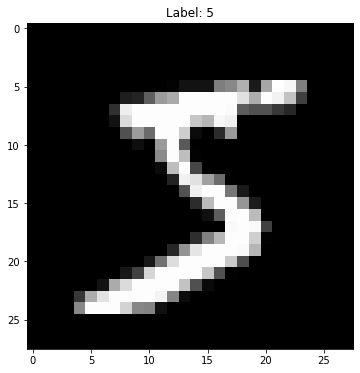

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.title('Label: ' + str(y[0]))
plt.show()

## Data Splitting

- Now, that we know the deatils such as number of samples, size of each sample, number of features (784), number of classes (targets) about the dataset, we can move on to the splitting and pre processing steps.
- We split the total no. of samples into train and test sets. Out of the total examples of $70000$, we keep $10000$ for testing and the remaining for training.
- Since, the samples in the dataset are already randomly shuffles, we need not shuffle it again. Therefor, I am not using `train_test_split` here.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before proceeding further, we need to check whether the dataset is balanced or imbalanced. We can do it by plotting the distribution of samples in each classes.

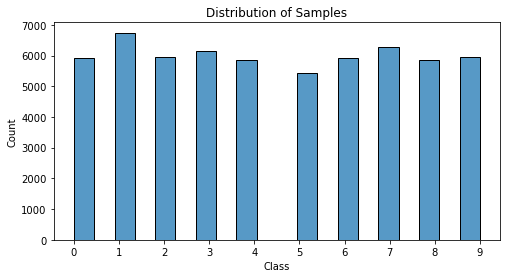

In [11]:
plt.figure(figsize=(8,4))
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=np.arange(10), labels=np.arange(10))
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

The data seems pretty balanced, as each label is almost equally represented.

# Binary Classification: 0 detector

## Modifying Labels

- We start with a simple classification problem, that is binary classification.
- Since the original label vector contains $10$ classes, we need to modify the no. of classes to just $2$.
- Therefore, the label $0$ will be changed to $1$ and all other labels ($1-9$) will be changed to $0$.
> **Note:** For perceptron we set the negative labels to $-1$.
- We name the label vectors as `y_train_0` and `y_test_0`.

Inorder to accomplish this, we define a helper function.

In [12]:
def bin_label_converter(y, class_name):
    '''Converts given multiclass label vector to one vs all binary form.
        Labels with labels `class_name` are assigned +1, and everything else is assigned -1.
    '''
    return np.where(y == class_name, 1, 0)

In [13]:
y_train_0, y_test_0 = bin_label_converter(y_train, '0'), bin_label_converter(y_test, '0')

Now, we conduct a sanity check. Let's display the elements of `y_train` and `y_train_0` to verify whether all the labels are properly modified or not.

We will conduct the check on a few examples.

In [14]:
print(y_train) # Original labels
print(y_train_0) # Modified labels

['5' '0' '4' ... '5' '6' '8']
[0 1 0 ... 0 0 0]


In [15]:
print(np.where(y_train == '0')) # index of labels with '0' in the original label vector
print(np.where(y_train_0 == 1)) # index of labels with '+1' in the modified label vector

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)


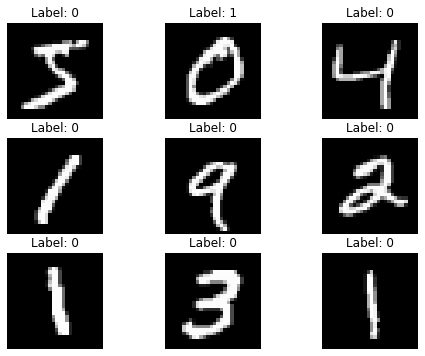

In [16]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X_train[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('Label: ' + str(y_train_0[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()

## Baseline Model

Let's construct a baseline model with the following rules:
1. Count the no. of samples per class.
2. The model always outputs the class with highest no. of samples.
3. Then we check the accuracy of the baseline model.

In [17]:
unique, counts = np.unique(y_train_0, return_counts=True)
print(unique, counts)

[0 1] [54077  5923]


As we can see, we have $54077$ occurences of $0$ and only $5923$ occurences of $1$, which means just returning $0$ should be a pretty decent baseline model.

In [18]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train_0)

DummyClassifier(strategy='most_frequent')

Now, we check the accuracy of this baseline model.

In [19]:
print("Score on Training Set: ", dummy_clf.score(X_train, y_train_0))
print("Score on Test Set: ", dummy_clf.score(X_test, y_test_0))

Score on Training Set:  0.9012833333333333
Score on Test Set:  0.902


The reason to this is obvious. The model would have predicted $54077$ samples correctly out of the $60000$ by just giving an output of $0$, irrespective of the input sample.

Therefore the accuracy will be $\frac{54077}{60000}$, which is around $90.12 \%$.

> This is the reason why **accuracy** alone is not always a good measure, as it can be hoodwinked fairely easily.

## Logistic Regression via `SGDClassifier`

Let's look at the `LogisticRegression` class from `sklearn.linear_model`.

`(class) LogisticRegression(penalty="l2", *, dual=False, tol=0.0001, C=1, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver="lbfgs", max_iter=100, multi_class="auto", verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)`

- Again, internally this is just a tweaked `SGDClassifier` (it implements the `log_loss`).

- So, another way of deploying Logistic Regression is to use the more general `sklearn.linear_model.SGDClassifier` with parameter `loss = 'log'`.

Let's look into the parameters of the `SGDClassifer` estimator:

`(class) SGDClassifier(loss="hinge", *, penalty="l2", alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=DEFAULT_EPSILON, n_jobs=None, random_state=None, learning_rate="optimal", eta0=0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)`

- So, we just the parameter to `loss = 'log'`, to make it a Logistic Regression Classifer.

- We can use the fit method of `SGDClassifier` to plot the iteration vs loss curve (Of course, we could use `partial_fit()` method as well).
- So, to capture the loss of each iterations during the training, we set the parameters `warm_start=True` and `max_iter=1`, to store the loss.

### Training without Regularization

- Set `eta = 0.01`, `learning_rate='constant'` and `alpha=0`

In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

bin_sgd_clf = SGDClassifier(
    loss='log', # This makes this a logistic regressor
    max_iter=1,
    warm_start=True, # max_iter=1, warm_start=True helps in plottitng the learning curve
    eta0=0.01,
    alpha=0, # No regularization
    learning_rate='constant',
    random_state=69,
)

loss_all = []
n_iterations = 100
# We will store the loss of first 100 iterations

for i in range(n_iterations):
    bin_sgd_clf.fit(X_train, y_train_0)
    y_train_0_pred = bin_sgd_clf.predict_proba(X_train)
    loss_all.append(log_loss(y_train_0, y_train_0_pred))

Let's plot the learning curve.

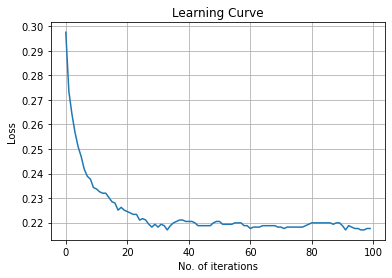

In [21]:
plt.figure()
plt.plot(np.arange(n_iterations), loss_all)
plt.grid(True)
plt.xlabel("No. of iterations")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.show()

Let's calculate the training and testing accuracy of the model.

In [22]:
print("Training Accuracy: ", bin_sgd_clf.score(X_train, y_train_0))
print("Test Accuracy: ", bin_sgd_clf.score(X_test, y_test_0))

Training Accuracy:  0.9937
Test Accuracy:  0.9919


- We know that accuracy alone is not a good metric for binary classification.
- Let's compute Precision, Recall and F1-score of this model (first on training, then on test).

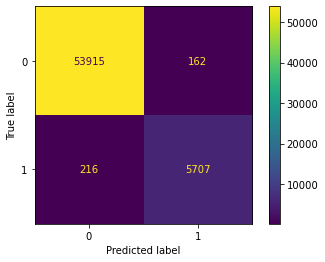

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_0_hat = bin_sgd_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_train_0_hat, values_format='.5g') # it returns matplotlib plot object
plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_train_0, y_train_0_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54077
           1       0.97      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



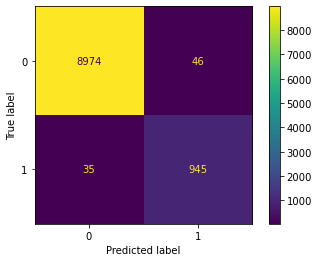

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

y_test_0_hat = bin_sgd_clf.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_test_0_hat, values_format='.5g') # it returns matplotlib plot object
plt.show()

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test_0, y_test_0_hat))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9020
           1       0.95      0.96      0.96       980

    accuracy                           0.99     10000
   macro avg       0.97      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



Now, we do cross validation to check the generalization ability of the model.

In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

estimator = SGDClassifier(
    loss = 'log',
    max_iter = 100, # We do not change warm_start = False
    eta0 = 0.01,
    alpha = 0, # No regularization
    learning_rate = 'constant',
    random_state = 69
)

scores = cross_validate(
    estimator,
    X_train,
    y_train_0,
    cv = 5, # So, 5 folds of cross validation
    scoring = ['precision', 'recall', 'f1'],
    return_train_score= True,
    return_estimator = True
)

pprint(scores)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=69),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=69),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=69),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=69),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=69)],
 'fit_time': array([1.3206532 , 1.27741814, 1.34319019, 1.26574492, 1.30740499]),
 'score_time': array([0.02105284, 0.01350713, 0.01303506, 0.01320601, 0.01359892]),
 'test_f1': array([0.95842083, 0.95481671, 0.96040868, 0.95422092, 0.95309257]),
 'test_precision': array([0.95321637, 0.96385542, 0.96907216, 0.94983278, 0.9379085 ]),

In [28]:
print("Precision: ", scores['test_precision'].mean(), scores['test_precision'].std())
print("Recall: ", scores['test_recall'].mean(), scores['test_recall'].std())
print("F1: ", scores['test_f1'].mean(), scores['test_f1'].std())

Precision:  0.9547770467111931 0.010937977766888794
Recall:  0.9577906545786293 0.008138169068671522
F1:  0.956191942107002 0.0027615642785581997


- From these results, it seems logistic regression is doing a lot better than perceptron!
- We can check the weight values of all the features and decide whether regularization could be of any help.

In [29]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_

print(weights.shape)
print(bias)

(1, 784)
[-4.86194945]


- Visualizing the value of weights.

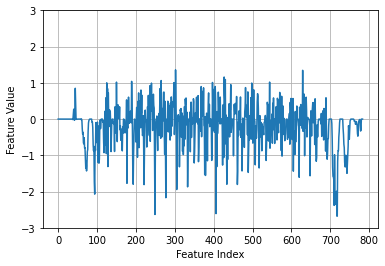

In [30]:
plt.figure()
plt.plot(np.arange(784), weights[0,:])
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.ylim(-3,3)
plt.grid(True)
plt.show()

- It is interesting to observe how many weight values are exactly zero.
- Those features contribute nothing in the classification (this correspond to the black regions in the picture around the borders).

In [31]:
num_zero_w = weights.shape[1] - np.count_nonzero(weights)
print("Number of weights with values zero: ", num_zero_w)

Number of weights with values zero:  67


From the above plot it is obvious that regularization is unnecessary as most of the weight values are within manageable range.

However, we can check for the sake of curiosity to see what happens to the performance of the model if we penalize, out of temptation, the weight values to an even smaller degree.

In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

bin_sgd_clf_l2 = SGDClassifier(
    loss='log',
    penalty='l2', # This is set to 'l2' by default
    alpha= 0.001, # We allow regularization this time
    max_iter= 1,
    eta0=0.01,
    warm_start=True, # We want to plot the learning curve after each iteration
    learning_rate='constant',
    random_state=69
)

loss_all = []
n_iterations = 100
# We will store the loss of first 100 iterations

for i in range(n_iterations):
    bin_sgd_clf_l2.fit(X_train, y_train_0)
    y_train_0_pred = bin_sgd_clf_l2.predict_proba(X_train)
    loss_all.append(log_loss(y_train_0, y_train_0_pred))

Let's plot the learning curve.

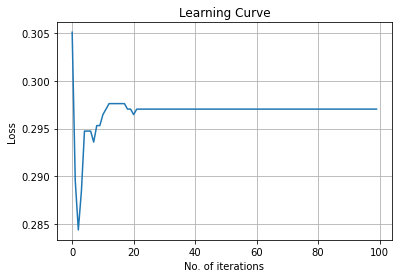

In [33]:
plt.figure()
plt.plot(np.arange(n_iterations), loss_all)
plt.grid(True)
plt.xlabel("No. of iterations")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.show()

Let's calculate the training and testing accuracy of the model.

In [34]:
y_train_0_hat = bin_sgd_clf_l2.predict(X_train)
y_test_0_hat = bin_sgd_clf_l2.predict(X_test)

In [35]:
print("Training Accuracy: ", bin_sgd_clf_l2.score(X_train, y_train_0))
print("Test Accuracy: ", bin_sgd_clf_l2.score(X_test, y_test_0))

Training Accuracy:  0.9914
Test Accuracy:  0.9913


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_train_0, y_train_0_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     54077
           1       0.98      0.94      0.96      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.97      0.98     60000
weighted avg       0.99      0.99      0.99     60000



In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test_0, y_test_0_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9020
           1       0.97      0.94      0.96       980

    accuracy                           0.99     10000
   macro avg       0.98      0.97      0.98     10000
weighted avg       0.99      0.99      0.99     10000



In [38]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_

print(weights.shape)
print(bias)

(1, 784)
[-4.45910246]


- Visualizing the value of weights.

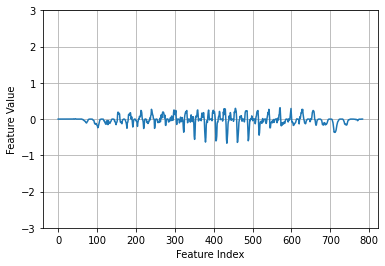

In [39]:
plt.figure()
plt.plot(np.arange(784), weights[0,:])
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.ylim(-3,3)
plt.grid(True)
plt.show()

As we can see, the weight coefficients are much lower.

In [40]:
num_zero_w = weights.shape[1] - np.count_nonzero(weights)
print("Number of weights with values zero: ", num_zero_w)

Number of weights with values zero:  67


### Displaying input image and its prediction

We display the prediction of the `SGDClassifier` with regularization on a test example.

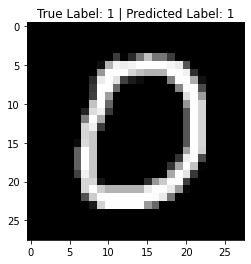

In [41]:
index = 10 # We can try any input index under 10000 (we have 10000 test examples)

plt.figure()
plt.imshow(X_test[index,:].reshape(28,28), cmap='gray')
plt.title("True Label: " + str(y_test_0[index]) + " | Predicted Label: " + str(y_test_0_hat[index]))
plt.show()

Let's plot a few images and their respective predicitions with `SGDClassifier` without regularization.

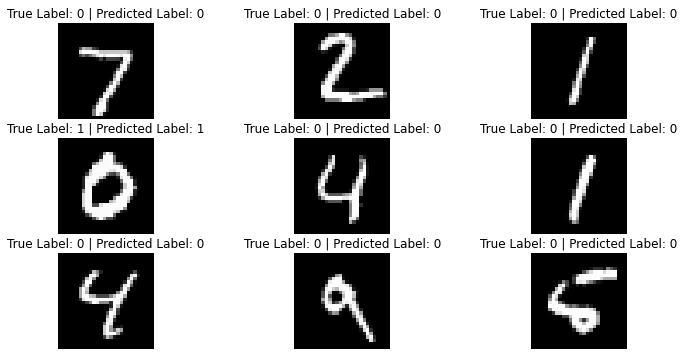

In [42]:
y_test_0_hat = bin_sgd_clf.predict(X_test)

num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(12,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X_test[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('True Label: ' + str(y_test_0[index]) + ' | Predicted Label: ' + str(y_test_0_hat[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()

Let's look at some of the examples which are labelled $1$.

In [43]:
index_pos = np.array(np.where(y_test_0 == 1)).reshape(-1,) # It lists out an array with indexes with have been labelled '1' in the test label set.
index_pos.shape

(980,)

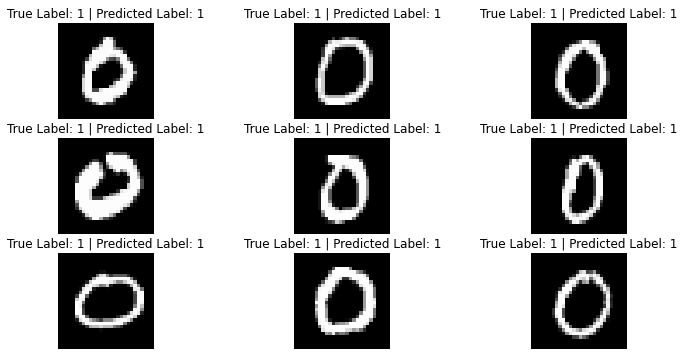

In [44]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(12,6))
# We plot 'num_images' many images following the index from the array of indices index_pos
i = 0
for row in range(factor):
    for col in range(factor):
        index = index_pos[i]
        ax[row,col].imshow(X_test[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('True Label: ' + str(y_test_0[index]) + ' | Predicted Label: ' + str(y_test_0_hat[index]))
        ax[row,col].set_axis_off()
        i += 1

plt.show()

### Hyper-parameter Tuning

- We can use cross-validation folds and measure the same metrics across these folds for different values of hyperparameters.
- Logistic Regression uses **sgd** solver and hence the learning rate and regularization rate are two important hyper-parameters.
- For the moment, we skip penalizing the parameters of the models and just search for the better learning rate via `RandomizedSearchCV` and draw the value from uniform distribution.

In [45]:
from scipy.stats import loguniform
lr_grid = loguniform(1e-2, 1e-1)

- Note that, `lr_grid` is an object that contains a method called `rvs()` which can be used to get the samples of a given size.
- Therefore, we pass this `lr_grid` object to `RandomizedSearchCV`. Internally, it makes use of this `rvs()` method for sampling.

In [46]:
print(type(lr_grid))
print(lr_grid.rvs(3, random_state=42))

<class 'scipy.stats._distn_infrastructure.rv_frozen'>
[0.02368864 0.0892718  0.05395031]


In [85]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV

estimator = SGDClassifier(
    loss='log',
    max_iter=1,
    warm_start=True,
    eta0=0.01,
    alpha=0, # Without regularization
    learning_rate='constant',
    random_state=69,
)

bin_sgd_rnd_cv = RandomizedSearchCV(
    estimator,
    param_distributions={
        'eta0': lr_grid,
    },
    cv=5,
    scoring=['precision', 'recall', 'f1'],
    n_iter=5,
    refit='f1',
    return_train_score=True,
)

bin_sgd_rnd_cv.fit(X_train, y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=69,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2f9fc83d0>},
                   refit='f1', return_train_score=True,
                   scoring=['precision', 'recall', 'f1'])

In [48]:
pprint(bin_sgd_rnd_cv.cv_results_)

{'mean_fit_time': array([0.27600994, 0.28654222, 0.29560199, 0.29237409, 0.29876404]),
 'mean_score_time': array([0.01420302, 0.0143733 , 0.01460543, 0.01445451, 0.01430259]),
 'mean_test_f1': array([0.95306713, 0.94793914, 0.95024464, 0.95171022, 0.95280165]),
 'mean_test_precision': array([0.95932865, 0.94057944, 0.94539896, 0.9494298 , 0.96547328]),
 'mean_test_recall': array([0.94715732, 0.95610745, 0.9557699 , 0.95458747, 0.94057133]),
 'mean_train_f1': array([0.95772216, 0.952163  , 0.95561483, 0.95693693, 0.95575611]),
 'mean_train_precision': array([0.96464567, 0.94399537, 0.95181079, 0.9563225 , 0.96855921]),
 'mean_train_recall': array([0.95112192, 0.96104068, 0.95990111, 0.95791738, 0.943398  ]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                   0.05395030966670228, 0.039687933304443715,
                   0.01432249371823025],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),

- Let's pick the best estimator from the results.

In [49]:
bin_sgd_rnd_cv.best_params_

{'eta0': 0.02368863950364078}

In [88]:
best_bin_clf = bin_sgd_rnd_cv.best_estimator_
best_bin_clf

SGDClassifier(alpha=0, eta0=0.011430983876313219, learning_rate='constant',
              loss='log', max_iter=1, random_state=69, warm_start=True)

### Classification Report and Precision Recall Tradeoffs

**Classification Report**

In [51]:
from sklearn.metrics import classification_report

y_test_0_hat = best_bin_clf.predict(X_test)
print(classification_report(y_test_0, y_test_0_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9020
           1       0.97      0.95      0.96       980

    accuracy                           0.99     10000
   macro avg       0.98      0.97      0.98     10000
weighted avg       0.99      0.99      0.99     10000



**Precision Recall Tradeoffs**

In [52]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import precision_recall_curve

y_scores = best_bin_clf.decision_function(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1) # pos_label denotes the labels of class '1'

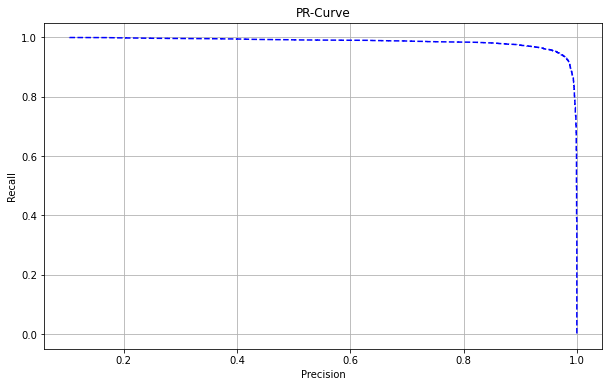

In [53]:
plt.figure(figsize=(10,6))
plt.plot(precisions[:-1], recalls[:-1], 'b--')
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR-Curve")
plt.grid(True)
plt.show()

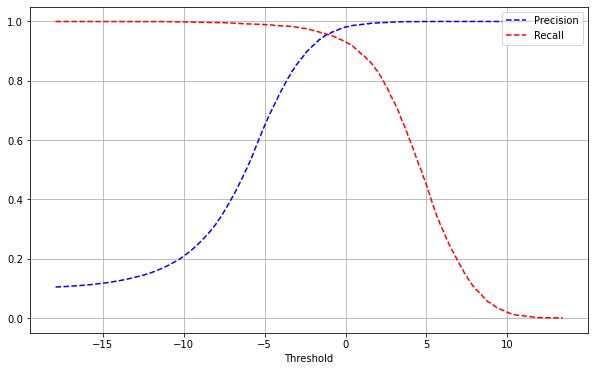

In [54]:
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
plt.plot(thresholds, recalls[:-1], 'r--', label="Recall")
plt.xlabel("Threshold")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

**ROC Curve**

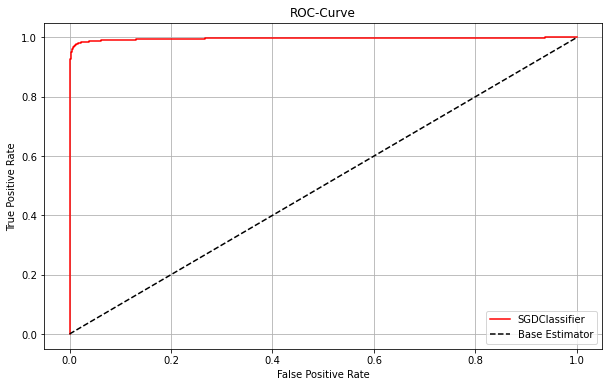

In [55]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, 'r-', label="SGDClassifier")
plt.plot([0,1], [0,1], 'k--', label="Base Estimator")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.title("ROC-Curve")
plt.show()

In [56]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_train_0, y_scores)
print("AUC: ", auc)

AUC:  0.9967318722940419


As we can see, the Area Under the Curve of the ROC Curve is around $0.99$ which is quite high, which means our model should perform reasonably well.

## Logistic Regression via `LogisticRegression`

- In the previous set up, we used `SGDClassifier` to train $0$-detector model in an iterative manner.
    - We can also train such a classifier by solving a set of equations obtained by setting the of loss w.r.t. weights to $0$.
    - These are not linear equations and therefore we need a different set of solvers.
- Sklearn uses solvers like `liblinear`, `newton-cg`, `sag`, `saga` and `lbfgs` to find the optimal weights.
    - `newton-cg` — A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the second derivatives.
    - `lbfgs` — Stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It approximates the second derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets. It will be the default solver.
    - `liblinear` — Library for Large Linear Classification. Uses a coordinate descent algorithm. Coordinate descent is based on minimizing a multivariate function by solving univariate optimization problems in a loop. In other words, it moves toward the minimum in one direction at a time. It is the default solver for Scikit-learn versions earlier than 0.22.0. It performs pretty well with high dimensionality. It does have a number of drawbacks. It can get stuck, is unable to run in parallel, and can only solve multi-class logistic regression with one-vs.-rest.
    - `sag` — Stochastic Average Gradient descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Fast for big datasets.
    - `saga` — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.

- The default learner changes for different settings for faster implementation.
![Penalties and Solvers](/Users/sampadk04/Desktop/Programming/VSCode-Projects/Python/IITM_Notes/IITM-MLP/W6_Classification_Models_(Image_Classification)_continued/LogisticRegression_solvers.png)

- Regularization is applied by default.
- Parameters:
`(class) LogisticRegression(penalty="l2", *, dual=False, tol=0.0001, C=1, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver="lbfgs", max_iter=100, multi_class="auto", verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)`
- Some of the important default parameters:
    - Regularization: `penatly='l2'`
    - Regularization rate: `C=1`
    - Solver: `solver='lbfgs'`

We will implement `LogisticRegression` **without regularization** by setting the parameter $C = \infty$ (the parameter $C$ can be thought of as the inverse of the regularization coefficient $\alpha$, so when we want $\alpha = 0$, we can set $C = \infty$). Therefore, we may expect the performance to be close to `SGDClassifier ` without regularization.

### Training without Regularization

- **STEP 1:** Instantiate a pipeline object with $2$ stages:
    - The first stage contains the `MinMaxScaler` for the scaling of the input.
    - The second stage contains `LogisticRegression` classifier with the regularization rate `C = np.infty`.
- **STEP 2:** Train the pipeline with feature matrix `X_train` and label vector `y_train_0`.

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

pipe_logit = Pipeline([
    ('mms', MinMaxScaler()),
    ('log_reg', LogisticRegression(
        random_state=69,
        solver='lbfgs',
        C=np.infty, # No regularization C = 1/alpha
    )),
])

pipe_logit.fit(X_train, y_train_0)

Pipeline(steps=[('mms', MinMaxScaler()),
                ('log_reg', LogisticRegression(C=inf, random_state=69))])

By executing this cell, we trained our `LogisticRegression` classifier, which can be used for making predictions on the new inputs.

## Hyper-parameter Search

In this section, we will search for the best value for the parameter `C` under certain `scoring` function

### with `GridSearchCV`

In the previous cell, we trained `LogisticRegression` classifer with `C = np.infty` (for an unregularized fitting). We can try searching for the best values of `C`. We will try to search using `GridSearchCV`.

> Note: This search can also be performed using `RandomizedSearchCV`.

Inorder to use `GridSearchCV`, we first define a set of values that we want to try out for `C`. The best value of `C`, will be chosen from this set.

We define the `pipeline` object exactly like before, with one exception: we have set the parameter value of `C` to `1` in the `LogisticRegression` estimator. We can set it to any value as th ebest value with be searched with grid search.

The additional step here is to instantiate a `GridSearchCV` object with a `pipeline` estimator, parameter grid specification and `f1` as a scoring function.

> Note that we can use other scoring functions like `precision`, `recall`, however the `C` is found such that the given scoring function is optimized.

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe_logit = Pipeline([
    ('mms', MinMaxScaler()),
    ('log_reg', LogisticRegression(
        random_state=69,
        solver='lbfgs',
        C=np.infty, # No regularization C = 1/alpha
    )),
])

grid_C = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]

pipe_logit_gscv = GridSearchCV(
    estimator=pipe_logit,
    param_grid={'log_reg__C' : grid_C},
    scoring='f1',
)

pipe_logit_gscv.fit(X_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('mms', MinMaxScaler()),
                                       ('log_reg',
                                        LogisticRegression(C=inf,
                                                           random_state=69))]),
             param_grid={'log_reg__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                        100.0, 1000.0]},
             scoring='f1')

The `GridSearchCV` finds the best value of `C` and refits the estimator by the default on the entire training set. This gives us the logistic regression classifier with best value of `C`.

We can check the value of the best parameter by accessing the `best_params_` member variabel of the `GridSearchCV` object.

In [62]:
pipe_logit_gscv.best_params_

{'log_reg__C': 0.1}

The best score can be found in `best_score_` member variable and can be obtained as follows:

In [63]:
pipe_logit_gscv.best_score_

0.9579654953103655

The best estimator can be accessed with the `best_estimator` member variable.

In [65]:
pipe_logit_best = pipe_logit_gscv.best_estimator_
pipe_logit_best

Pipeline(steps=[('mms', MinMaxScaler()),
                ('log_reg', LogisticRegression(C=0.1, random_state=69))])

### with `LogisticRegressionCV`

Instead of using `GridSearchCV` for finding the best value for the parameter `C`, we can also use `LogisticRegressionCV` for performing the same job.

- **STEP 1:** Here, we make use of `LogisticRegressionCV` estimator with a no. of cross validation folds `cv=5` and scoring scheme `scoring='f1'` in the `pipeline` object.

- **STEP 2:** In the second step, we train the pipeline object as before.

In [69]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

logit_cv = make_pipeline(
    MinMaxScaler(),
    LogisticRegressionCV(
        cv=5,
        scoring='f1',
        random_state=69
    )
)

logit_cv.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=69, scoring='f1'))])

By default, `LogisticRegressionCV` refits the model on the entire training set with the best parameter values obtained via cross validation.

## Performance Evaluation

### Precision, Recall and F1-score

Let's evaluate the performance of these three different logistic regression classifiers for detecting digit $0$ from the image.
- Logistic Regression without regularization
- Best Logistic Regression found through `GridSearchCV`.
- Best classifier found through `LogisticRegressionCV`

> Note that `GridSearchCV` and `LogisticRegressionCV` by default refit the classifier for the best hyperparameter values. So, we can predict directly by using the object's best estimator.

In [73]:
lr_y_test_0_hat = pipe_logit.predict(X_test)
lr_gs_y_test_0_hat = pipe_logit_gscv.best_estimator_.predict(X_test)
lr_cv_y_test_0_hat = logit_cv.predict(X_test)

We will compare the **precision**, **recall** and **f1-score** for the three classifiers:

In [74]:
from sklearn.metrics import precision_score, recall_score

precision_lr = precision_score(y_test_0, lr_y_test_0_hat)
recall_lr = recall_score(y_test_0, lr_y_test_0_hat)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_test_0_hat)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_test_0_hat)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_test_0_hat)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_test_0_hat)

In [75]:
print(f"LogReg: precision = {precision_lr}, recall = {recall_lr}")
print(f"GridSearch: precision = {precision_lr_gs}, recall = {recall_lr_gs}")
print(f"LogRegCV: precision = {precision_lr_cv}, recall = {recall_lr_cv}")

LogReg: precision = 0.9515151515151515, recall = 0.9612244897959183
GridSearch: precision = 0.9564336372847011, recall = 0.963265306122449
LogRegCV: precision = 0.9546370967741935, recall = 0.9663265306122449


Note that all the three classifers have roughly the same performance as measures with precision and recall.
- `LogisticRegression` classifier on=btained through `GridSearchCV` has the highest precision - marginally higher than the other $2$ classifiers.
- `LogisticRegression` classifier on=btained through `LogisticRegressionCV` has the higher recall - marginally higher than the other $2$ classifiers.

### Using PR Curve

In [76]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = pipe_logit.decision_function(X_test)
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_test_0, y_scores_lr)

y_scores_lr_gs = pipe_logit_gscv.decision_function(X_test)
precisions_lr_gs, recalls_lr_gs, thresholds_lr_gs = precision_recall_curve(y_test_0, y_scores_lr_gs)

y_scores_lr_cv = logit_cv.decision_function(X_test)
precisions_lr_cv, recalls_lr_cv, thresholds_lr_cv = precision_recall_curve(y_test_0, y_scores_lr_cv)

We have all the requisite quantities for plotting hte PR Curve. Let's plot the PR curves for all three classifiers:

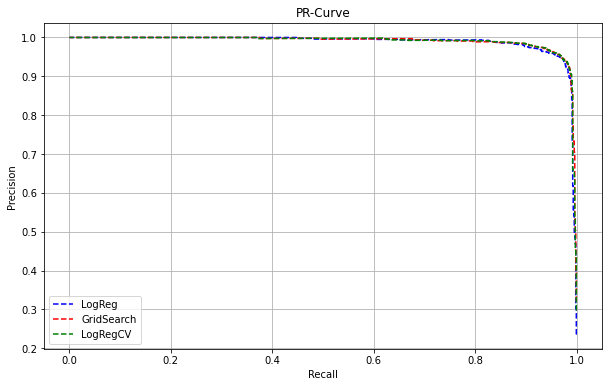

In [79]:
plt.figure(figsize=(10,6))
plt.plot(recalls_lr[:-1], precisions_lr[:-1], 'b--', label="LogReg")
plt.plot(recalls_lr_gs[:-1], precisions_lr_gs[:-1], 'r--', label="GridSearch")
plt.plot(recalls_lr_cv[:-1], precisions_lr_cv[:-1], 'g--', label="LogRegCV")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-Curve")
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

Note that the PR curves for all three classifiers overlap significantly.

Let's calculate the area under the PR Curve:

In [80]:
from sklearn.metrics import auc

auc_lr = auc(recalls_lr[:-1], precisions_lr[:-1])
auc_lr_gs = auc(recalls_lr_gs[:-1], precisions_lr_gs[:-1])
auc_lr_cv = auc(recalls_lr_cv[:-1], precisions_lr_cv[:-1])

print("AUC-PR for logistic regression: ", auc_lr)
print("AUC-PR for grid search: ", auc_lr_gs)
print("AUC-PR for logistic regression CV: ", auc_lr_cv)

AUC-PR for logistic regression:  0.9871337497759658
AUC-PR for grid search:  0.9886520703587929
AUC-PR for logistic regression CV:  0.9886303652779903


Observe that the AUC for all three classifiers is roughly the same with `LogisticRegression` classifier obtained through cross validation and grid search have slightly higher AUC under the PR Curve.

### Confusion Matrix

We show a confusion matrix for test set with logistic regression classifier:

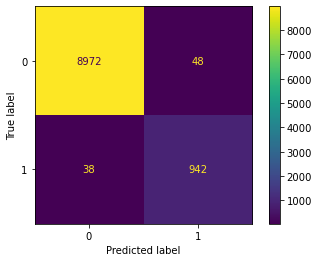

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_y_test_0_hat, values_format='.5g') # It returns matplotlib plot object
plt.show()

We show a confusion matrix for test set with logistic regression classifier obtained through grid search:

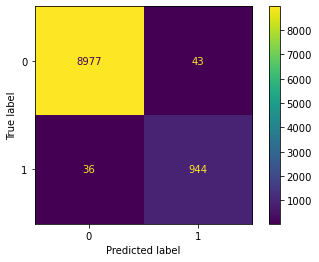

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gs_y_test_0_hat, values_format='.5g') # It returns matplotlib plot object
plt.show()

We show a confusion matrix for test set with logistic regression classifier obtained through cross validation:

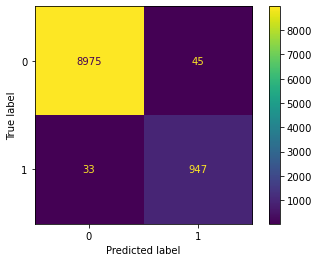

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_cv_y_test_0_hat, values_format='.5g') # It returns matplotlib plot object
plt.show()

## Further Exploration

Let's see what these classifiers learnt about the digit $0$.

<Figure size 432x432 with 0 Axes>

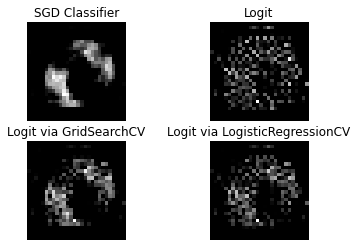

In [90]:
models = (best_bin_clf, pipe_logit[-1], pipe_logit_best[-1], logit_cv[-1]) # All are estimators
titles = ("SGD Classifier", "Logit", "Logit via GridSearchCV", "Logit via LogisticRegressionCV")

plt.figure(figsize=(6,6))
plt.subplots(2,2)
for i in range(4):
    w = models[i].coef_
    w_matrix = w.reshape(28,28)
    w_matrix[w_matrix < 0] = 0 # Set the values less than zero to zero, to bring out more contrast
    plt.subplot(2,2, i+1)
    plt.imshow(w_matrix, cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
    plt.grid(False)
plt.show()

# Multiclass Classifier (One vs All)

## Multiclass Logit with SGD

In [102]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

pipe_sgd_ovr = make_pipeline(
    MinMaxScaler(),
    SGDClassifier(
        loss='log',
        max_iter=1,
        warm_start=True, # We want to store the loss after every iteration to plot the learning curve
        eta0 = 0.01,
        alpha=0, # Without regularization
        learning_rate='constant',
        random_state=69
    )
)

In [104]:
from sklearn.metrics import log_loss

loss_all = []
n_iterations = 100
# We will store the loss of first 100 iterations

for i in range(n_iterations):
    pipe_sgd_ovr.fit(X_train, y_train)
    y_train_pred = pipe_sgd_ovr.predict_proba(X_train)
    loss_all.append(log_loss(y_train, y_train_pred))

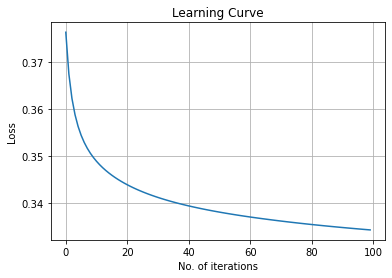

In [105]:
plt.figure()
plt.plot(np.arange(n_iterations), loss_all)
plt.grid(True)
plt.xlabel("No. of iterations")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.show()

- What happened behind the scenes?

The `SGDClassifier` automatically created $10$ binary classifiers and trained them! During the inference time, input will be passed through all the $10$ classifiers and the highest score among the outputs will be considered as the predicted class. To see it in action, let's execute the following lines of code.

In [106]:
pipe_sgd_ovr[-1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=1, random_state=69, warm_start=True)

In [107]:
weights = pipe_sgd_ovr[-1].coef_
weights.shape

(10, 784)

So, it is a matrix of size $10 \times 784$. A row represents the weights corresponding to a single binary classifier.

In [108]:
y_test_hat = pipe_sgd_ovr.predict(X_test)
y_test_hat[:5]

array(['7', '2', '1', '0', '4'], dtype='<U1')

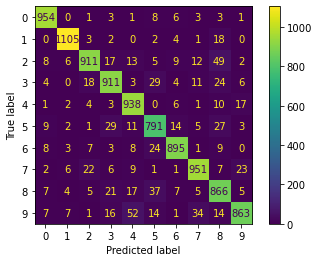

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, values_format='.5g')

In [110]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.94      0.88      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.89      0.96      0.92       982
           5       0.87      0.89      0.88       892
           6       0.95      0.93      0.94       958
           7       0.93      0.93      0.93      1028
           8       0.84      0.89      0.87       974
           9       0.94      0.86      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## Multiclass `LogisticRegression` using solvers

In [111]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

pipe_logit_ovr = make_pipeline(
    MinMaxScaler(),
    LogisticRegression(
        solver='lbfgs',
        C = np.infty, # no regularization
        random_state=69
    )
)

pipe_logit_ovr.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=69))])

In [112]:
y_test_hat = pipe_logit_ovr.predict(X_test)
y_test_hat[:5]

array(['7', '2', '1', '0', '4'], dtype=object)

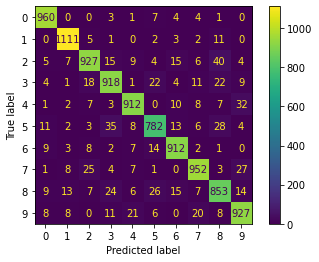

In [113]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, values_format='.5g')

In [114]:
weights = pipe_logit_ovr[-1].coef_
weights.shape

(10, 784)

### Let's visualize the weights pictorially

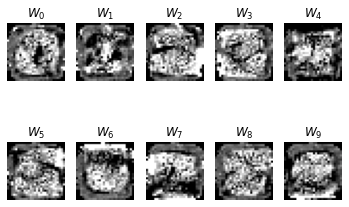

In [117]:
# normalize the weights
W = MinMaxScaler().fit_transform(weights)

fig, ax = plt.subplots(2, 5)
index = 0
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(W[index,:].reshape(28,28), cmap='gray')
        ax[i][j].set_title("$W_{0}$".format(index))
        ax[i][j].set_axis_off()
        index += 1

## Prediction on the Test Set

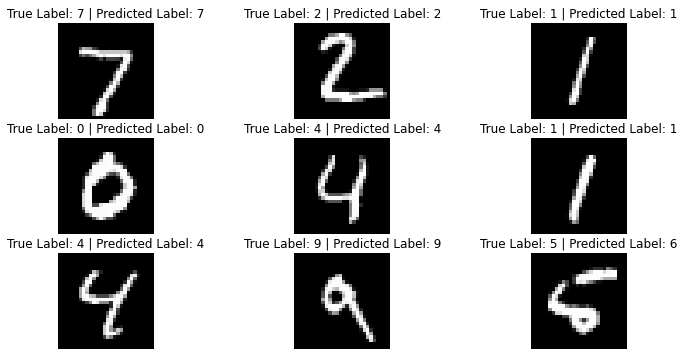

In [118]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(12,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X_test[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('True Label: ' + str(y_test[index]) + ' | Predicted Label: ' + str(y_test_hat[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()